## Model Evaluation 

The following script allows for model evaluation.

In [1]:
# Imports 
import tensorflow as tf

import dlomix 
from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import load_processed_dataset
from dlomix.constants import ALPHABET_NAIVE_MODS

from collections import Counter
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

2024-06-30 16:47:49.828003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 16:47:49.828076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 16:47:49.829707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 16:47:49.839479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 16:47:51.433740: W tensorflow/compiler/tf2


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



### Model

In [2]:
# Model directory and run name 
MODEL_DIR = '/cmnfs/proj/bmpc_dlomix/models/baseline_models/noptm_baseline_full_bs1024_naivemods/'
RUN_NAME = 'd961f940-d142-4102-9775-c1f8b4373c91'

In [3]:
# Load the model
model = tf.keras.models.load_model(
    MODEL_DIR + RUN_NAME + '.keras', 
    custom_objects={'masked_spectral_distance': dlomix.losses.masked_spectral_distance}
    )
print(model.summary())

2024-06-30 16:47:58.428989: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "prosit_intensity_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  432       
                                                                 
 sequential (Sequential)     (None, 30, 512)           1996800   
                                                                 
 sequential_1 (Sequential)   multiple                  4608      
                                                                 
 sequential_2 (Sequential)   (None, 29, 512)           1576806   
                                                                 
 encoder_att (AttentionLaye  multiple                  542       
 r)                                                              
                                                                 
 sequential_3 (Sequential)   multiple                  0         
                                        

### Datasets

In [4]:
# check performance of model on the test set without modifications
baseline_data = load_processed_dataset('/cmnfs/proj/bmpc_dlomix/datasets/processed/noptm_baseline_small_bs1024_unmod_extended')

# load a small dataset which contains only the new modification K[UNIMOD:122] as well as the other ones present in ALPHABET_NAIVE_MODS
mod_data = load_processed_dataset('/cmnfs/proj/bmpc_dlomix/datasets/processed/kmod_formyl')


### Data exploration

In [5]:
baseline_data

DatasetDict({
    train: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 7988
    })
    val: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 3993
    })
    test: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 2000
    })
})

In [ ]:
pd.DataFrame(baseline_data["train"])

In [6]:
def plot_precursor_charges(dataset_dict):
    """
    Plots the distribution of precursor charges for train, val, and test sets.
    """
    datasets = ['train', 'val', 'test']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for i, dataset in enumerate(datasets):
        charges = np.argmax(dataset_dict[dataset]['precursor_charge_onehot'], axis=1)
        axes[i].hist(charges, bins=np.arange(charges.max() + 2) - 0.5, edgecolor='black')
        axes[i].set_title(f'{dataset.capitalize()} Set')
        axes[i].set_xlabel('Precursor Charge')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

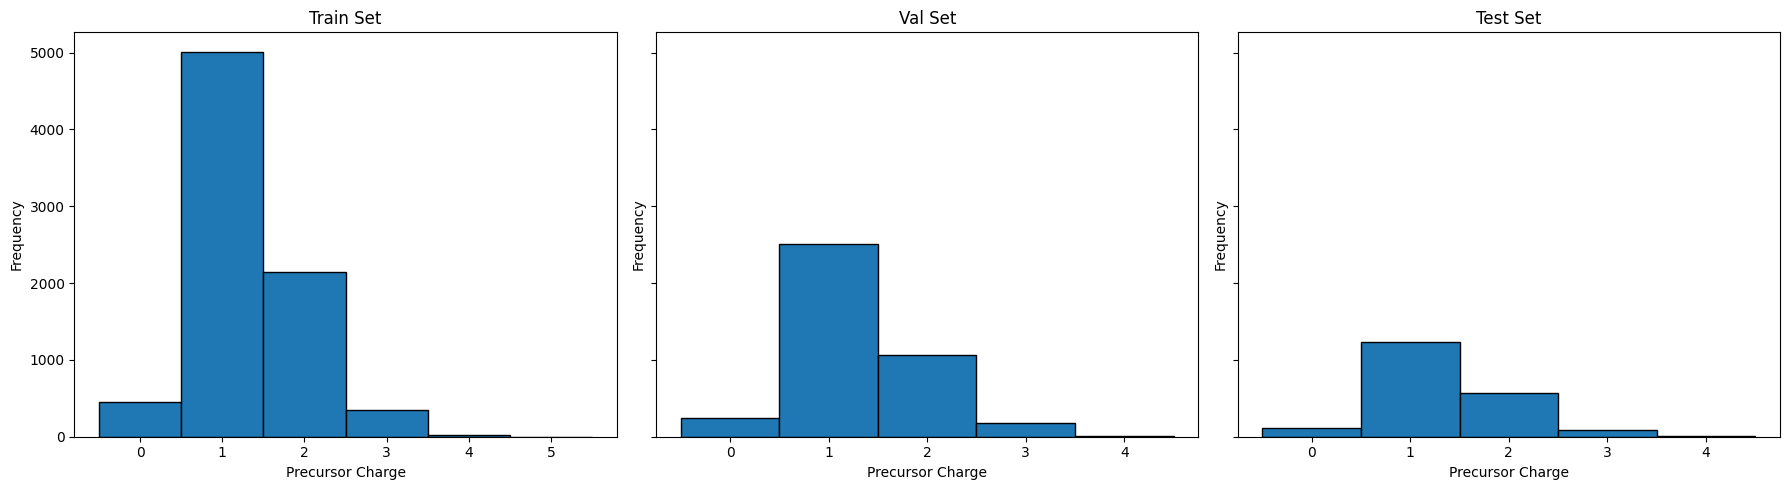

In [7]:
plot_precursor_charges(baseline_data)

In [30]:
def plot_amino_acid_predictions(dataset_dict, alphabet):
    """
    Plots the frequency of each amino acid in the sequences for train, val, and test sets.
    """
    datasets = ['train', 'val', 'test']
    fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharey=True)
    for i, dataset in enumerate(datasets):
        sequences = dataset_dict[dataset]['_parsed_sequence']
        aa_counts = {aa: 0 for aa in alphabet}
        for seq in sequences:
            for aa in seq:
                if aa in aa_counts:
                    aa_counts[aa] += 1
        aa_counts = dict(sorted(aa_counts.items()))
        axes[i].bar(aa_counts.keys(), aa_counts.values(), edgecolor='black')
        axes[i].set_title(f'{dataset.capitalize()} Set')
        axes[i].set_xlabel('Amino Acid')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

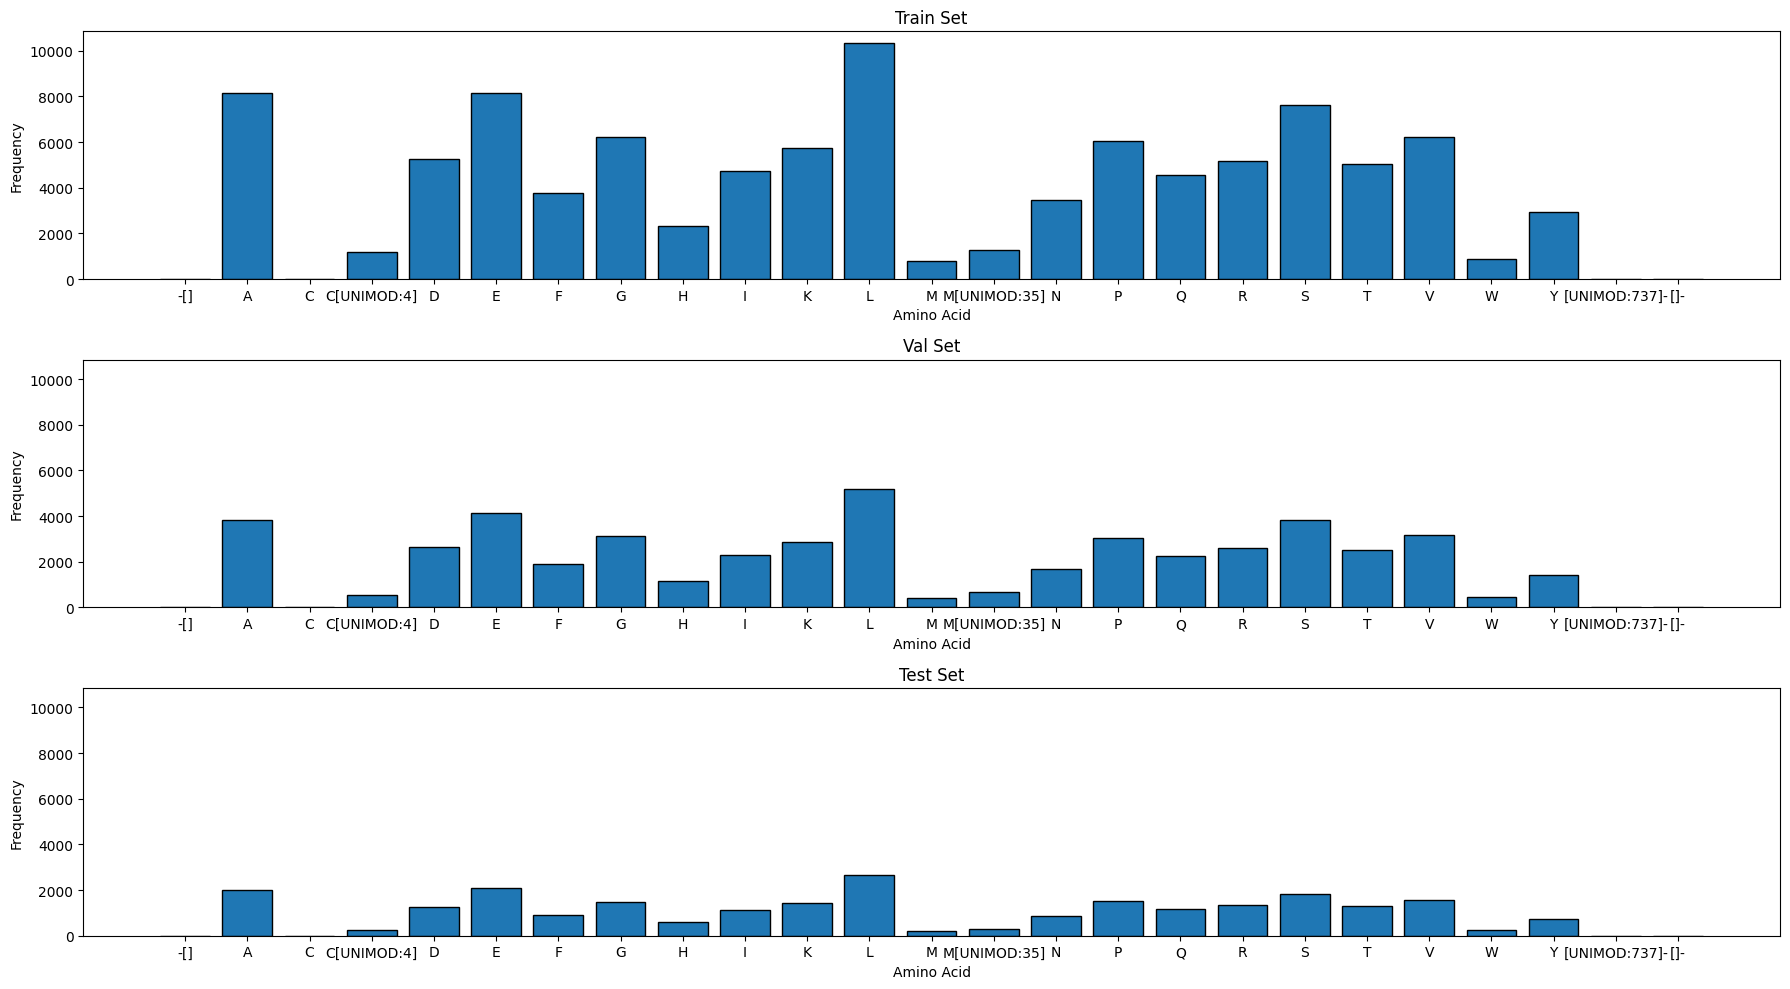

In [31]:
plot_amino_acid_predictions(baseline_data, ALPHABET_NAIVE_MODS.keys())

In [10]:
def plot_collision_energy_distribution(dataset_dict):
    """
    Plots the distribution of collision energies for train, val, and test sets.
    """
    datasets = ['train', 'val', 'test']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for i, dataset in enumerate(datasets):
        collision_energies = dataset_dict[dataset]['collision_energy_aligned_normed']
        axes[i].hist(collision_energies, bins=30, edgecolor='black')
        axes[i].set_title(f'{dataset.capitalize()} Set')
        axes[i].set_xlabel('Collision Energy')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

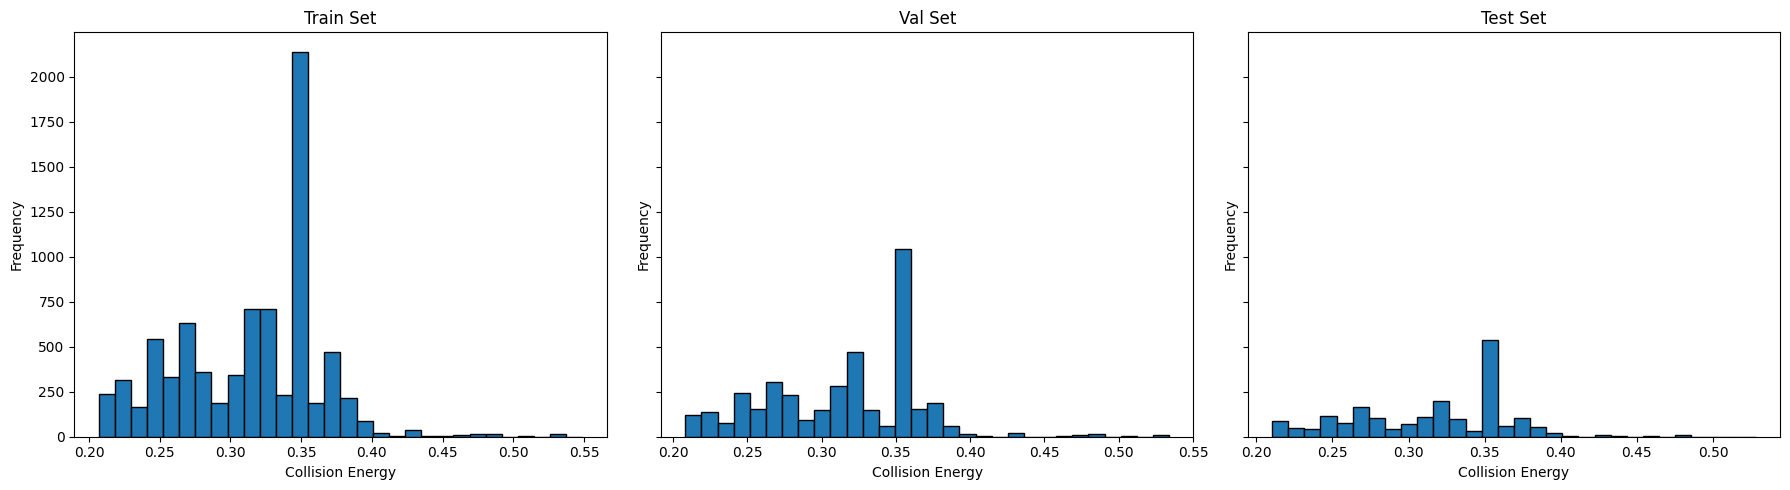

In [11]:
plot_collision_energy_distribution(baseline_data)

In [12]:
def plot_sequence_length_distribution(dataset_dict):
    """
    Plots the distribution of sequence lengths for train, val, and test sets.
    """
    datasets = ['train', 'val', 'test']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for i, dataset in enumerate(datasets):
        sequences = dataset_dict[dataset]['_parsed_sequence']
        lengths = [len(seq) for seq in sequences]
        axes[i].hist(lengths, bins=range(1, max(lengths) + 1), edgecolor='black')
        axes[i].set_title(f'{dataset.capitalize()} Set')
        axes[i].set_xlabel('Sequence Length')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

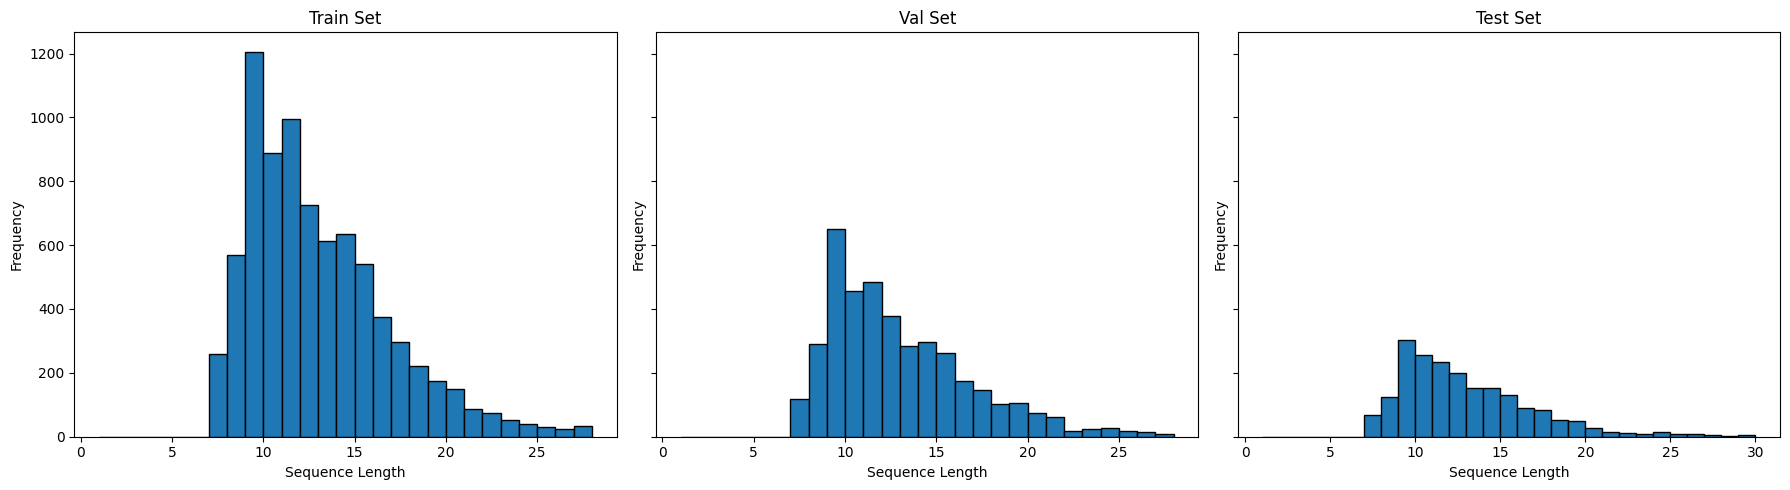

In [13]:
plot_sequence_length_distribution(baseline_data)

In [15]:
import pandas as pd
from collections import Counter
import numpy as np

def process_datasets(datasets):
    def get_charge(onehot_array):
        """Return the charge based on the one-hot encoded array."""
        return np.argmax(onehot_array) + 1  # Adding 1 since charges are 1, 2, 3, ...

    def peptide_length(sequence):
        """Return the length of the peptide sequence."""
        return len(sequence)

    def count_combinations(data):
        """Count the occurrences of each peptide length and precursor charge combination."""
        lengths = [peptide_length(seq) for seq in data['_parsed_sequence']]
        charges = [get_charge(charge) for charge in data['precursor_charge_onehot']]
        combinations = list(zip(lengths, charges))
        counter = Counter(combinations)
        return counter

    results = {}
    for key, df in datasets.items():
        counter = count_combinations(df)
        result_df = pd.DataFrame(counter.items(), columns=['Combination', 'Count'])
        result_df[['Peptide Length', 'Precursor Charge']] = pd.DataFrame(result_df['Combination'].tolist(), index=result_df.index)
        result_df = result_df.drop(columns=['Combination'])
        result_df = result_df[['Peptide Length', 'Precursor Charge', 'Count']]
        result_df = result_df.sort_values(by=['Peptide Length', 'Precursor Charge']).reset_index(drop=True)
        results[key] = result_df
    
    return results

In [16]:
results = process_datasets(baseline_data)

print('Train table')
results['train']

Train table


,Peptide Length,Precursor Charge,Count
0,7,1,15
1,7,2,243
2,8,1,71
3,8,2,471
4,8,3,27
...,...,...,...
77,27,4,7
78,27,5,2
79,28,3,11
80,28,4,1


In [19]:
print('Validation table')
results['val']

Validation table


,Peptide Length,Precursor Charge,Count
0,7,1,5
1,7,2,113
2,8,1,40
3,8,2,241
4,8,3,10
...,...,...,...
70,27,3,2
71,27,4,2
72,27,5,1
73,28,3,1


In [18]:
print('Test table')
results['test']

Test table


,Peptide Length,Precursor Charge,Count
0,7,1,6
1,7,2,60
2,7,3,1
3,8,1,10
4,8,2,112
...,...,...,...
69,28,4,1
70,29,3,1
71,29,4,1
72,30,3,1


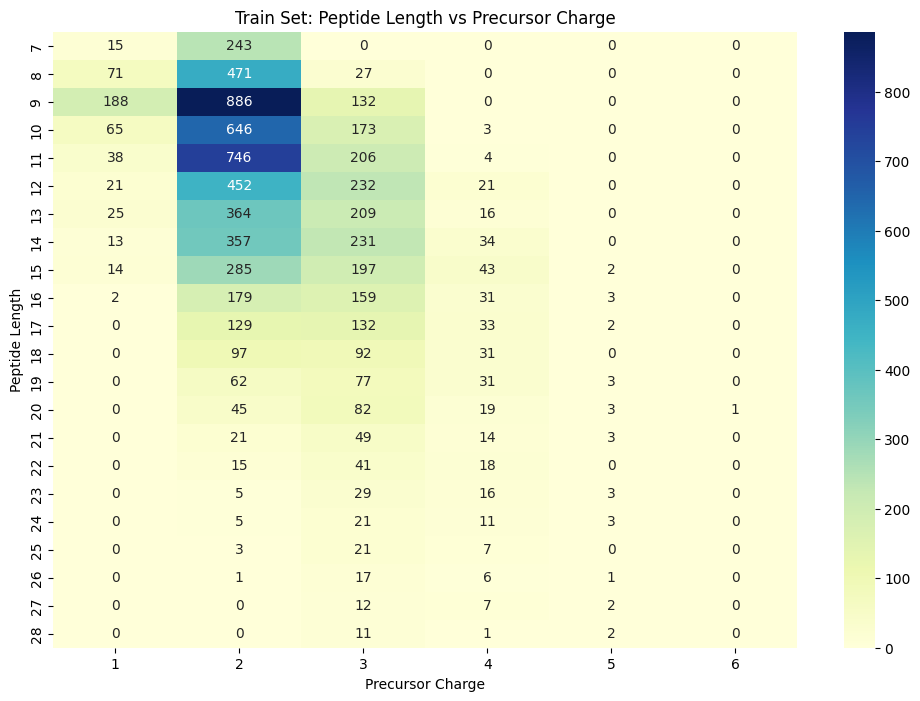

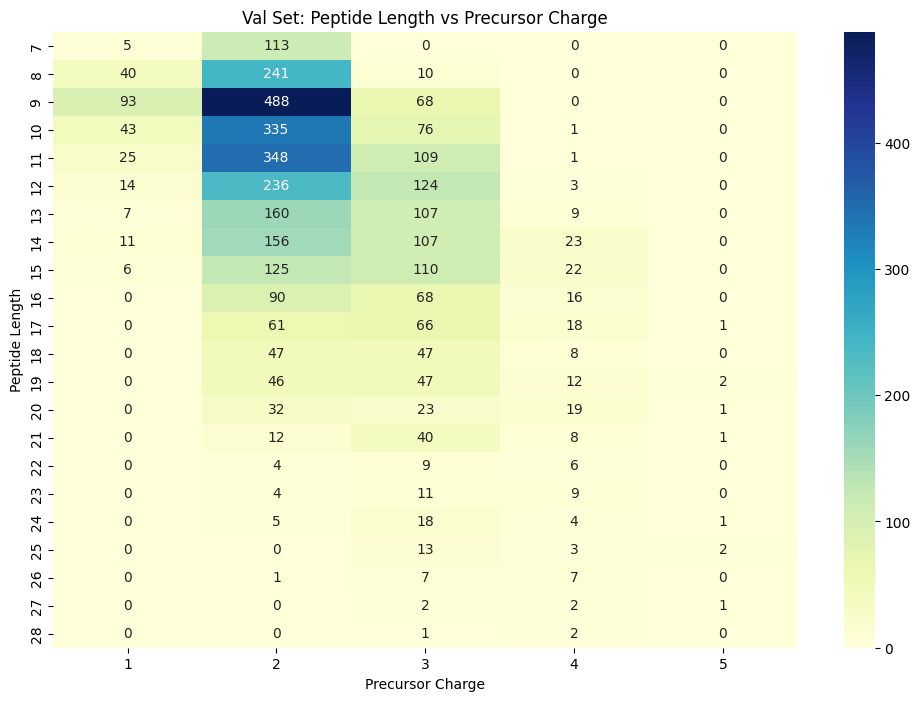

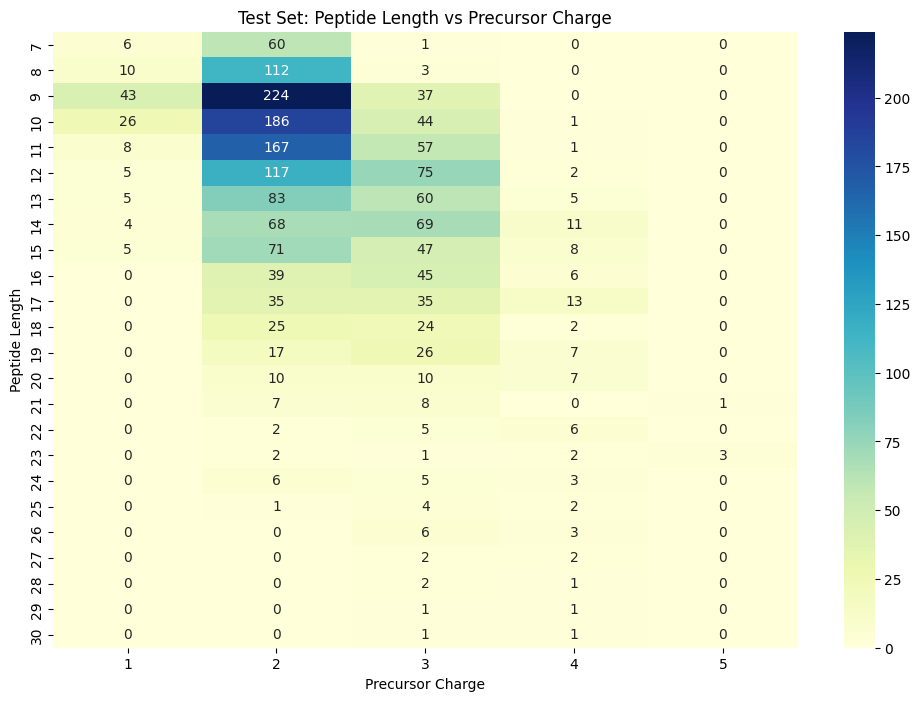

In [43]:
def plot_heatmap(df, title):
    """
    Plots a heatmap of the peptide length and precursor charge combinations.
    """
    # Ensure counts are treated as integers
    df['Count'] = df['Count'].astype(int)
    
    # Create a pivot table to structure the data for the heatmap
    pivot_table = df.pivot_table(index="Peptide Length", columns="Precursor Charge", values="Count", fill_value=0, aggfunc='sum')
    
    # Ensure the pivot table has integer values
    pivot_table = pivot_table.fillna(0).astype(int)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Precursor Charge")
    plt.ylabel("Peptide Length")
    plt.show()

# Plot each dataset
for key, df in results.items():
    plot_heatmap(df, f'{key.capitalize()} Set: Peptide Length vs Precursor Charge')


In [158]:
# Calculate spectral distances
pearson_corr_dists = calculate_pearson_correlation_distance(baseline_data, model, data_type='test')

avg_pearson_correlation_dist = np.mean(pearson_corr_dists)

print(f'Average Pearson Correlation distance: {avg_pearson_correlation_dist}')

Max value:  26
Min value:  0
32/32 [==============================] - 3s 85ms/step
Max value:  26
Min value:  0
31/31 [==============================] - 3s 83ms/step
Average Pearson Correlation distance: 0.19152456521987915


In [149]:
baseline_data

DatasetDict({
    train: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 7988
    })
    val: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 3993
    })
    test: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 2000
    })
})

In [ ]:
val_table = create_peptide_charge_table(baseline_data, 'val')
test_table = create_peptide_charge_table(baseline_data, 'test')

TypeError: '_PrefetchDataset' object is not subscriptable

In [108]:
def plot_intensity_distribution(dataset_dict):
    """
    Plots the distribution of intensities for train, val, and test sets.
    """
    datasets = ['train', 'val', 'test']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for i, dataset in enumerate(datasets):
        intensities = dataset_dict[dataset]['intensities_raw']
        flattened_intensities = [intensity for sublist in intensities for intensity in sublist]
        axes[i].hist(flattened_intensities, bins=30, edgecolor='black')
        axes[i].set_title(f'{dataset.capitalize()} Set')
        axes[i].set_xlabel('Intensity')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

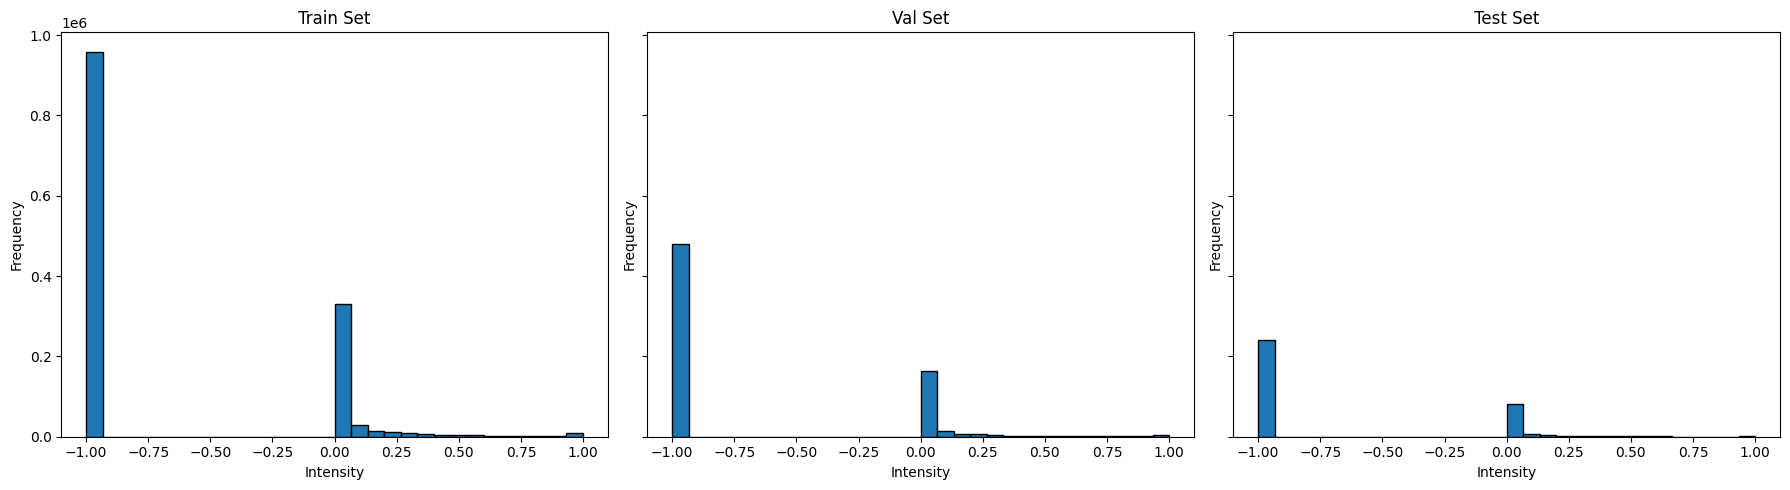

In [109]:
plot_intensity_distribution(baseline_data)

### Spectral Angle Distribution

In [70]:
def calculate_spectral_distance(data, model, data_type='val'):
    """
    Predict the intensities and calculate spectral distance between predictions and true intensities.

    Args:
        data: A dataset containing tensor_val_data and tensor_test_data.
        model: A trained model used for making predictions.
        data_type: A string indicating which dataset to use ('val' for tensor_val_data, 'test' for tensor_test_data).

    Returns:
        sd_new_mod: A list of spectral distances for each batch.
    """
    spectral_dists = list()

    if data_type == 'val':
        dataset = data.tensor_val_data
    elif data_type == 'test':
        dataset = data.tensor_test_data
    else:
        raise ValueError("Invalid data_type. Choose 'val' or 'test'.")

    for batch, y_true in dataset:
        print('Max value: ', batch['modified_sequence'].numpy().max())
        print('Min value: ', batch['modified_sequence'].numpy().min())
        
        y_pred = model.predict(batch)
        spectral_dists.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

    return spectral_dists


In [71]:
def plot_spectral_angle_distribution(spectral_dists, title, text_position=(0.2, 100)):
    """
    Plots the distribution of spectral angles and calculates the average spectral angle.

    Args:
        sd_data: A list of spectral distances.
        title: Title for the plot.
        text_position: A tuple indicating the position of the average spectral angle text on the plot.

    Returns:
        None
    """
    # Calculate spectral angles
    sa_data = [1 - sd for sd in spectral_dists]
    avg_sa = np.mean(sa_data)
    
    # Plot histogram
    p = sns.histplot(sa_data)
    p.text(text_position[0], text_position[1], f'Avg. SA = {avg_sa:.2f}')
    plt.title(title)
    plt.xlabel('Spectral Angle')
    plt.tight_layout()
    plt.show()


Max value:  26
Min value:  0
32/32 [==============================] - 3s 83ms/step
Max value:  26
Min value:  0
31/31 [==============================] - 3s 82ms/step


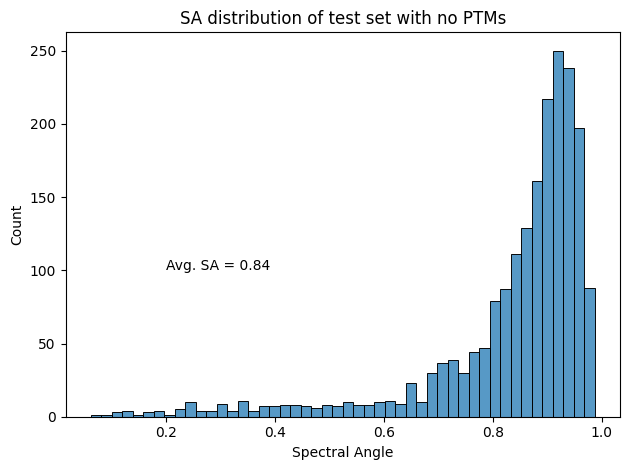

In [123]:
# Calculate spectral distances
spectral_dists_baseline = calculate_spectral_distance(baseline_data, model, data_type='test')

# Distribution of spectral angles on baseline test set
plot_spectral_angle_distribution(spectral_dists_baseline, 'SA distribution of test set with no PTMs')

Max value:  26
Min value:  0
32/32 [==============================] - 3s 85ms/step
Max value:  26
Min value:  0
25/25 [==============================] - 2s 82ms/step


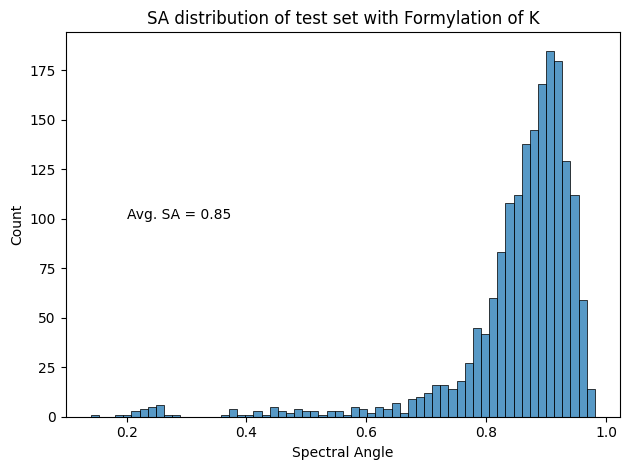

In [122]:
# Calculate spectral distances
spectral_dists_mod = calculate_spectral_distance(mod_data, model, data_type='val')

# Distribution of spectral angles on the dataset with new modification
plot_spectral_angle_distribution(spectral_dists_mod, 'SA distribution of test set with Formylation of K')

### Pearson Correlation Distance


In [129]:
def calculate_pearson_correlation_distance(data, model, data_type='val'):
    """
    Predict the intensities and calculate Pearson correlation distance between predictions and true intensities.

    Args:
        data: A dataset containing tensor_val_data and tensor_test_data.
        model: A trained model used for making predictions.
        data_type: A string indicating which dataset to use ('val' for tensor_val_data, 'test' for tensor_test_data).

    Returns:
        pearson_dists: A list of Pearson correlation distances for each batch.
    """
    pearson_dists = []

    if data_type == 'val':
        dataset = data.tensor_val_data
    elif data_type == 'test':
        dataset = data.tensor_test_data
    else:
        raise ValueError("Invalid data_type. Choose 'val' or 'test'.")

    for batch, y_true in dataset:
        print('Max value: ', batch['modified_sequence'].numpy().max())
        print('Min value: ', batch['modified_sequence'].numpy().min())
        
        y_pred = model.predict(batch)
        pearson_dist = masked_pearson_correlation_distance(y_true=y_true, y_pred=y_pred).numpy()
        pearson_dists.append(pearson_dist)

    return pearson_dists


In [133]:
# Calculate spectral distances
pearson_corr_dists = calculate_pearson_correlation_distance(baseline_data, model, data_type='test')

avg_pearson_correlation_dist = np.mean(pearson_corr_dists)

print(f'Average Pearson Correlation distance: {avg_pearson_correlation_dist}')

Max value:  26
Min value:  0
32/32 [==============================] - 3s 82ms/step
Max value:  26
Min value:  0
31/31 [==============================] - 3s 81ms/step
Average Pearson Correlation distance: 0.19152456521987915


### Modification Count

In [ ]:
def count_modification_instances(mod_data, alphabet, modification_name, modification_value, data_type='train'):
    """
    Updates the modification alphabet, counts the instances of a specified modification in the dataset,
    and prints the results.

    Args:
        mod_data: A dataset containing tensor_train_data, tensor_val_data, and tensor_test_data.
        alphabet: The alphabet dictionary to be updated with the new modification.
        modification_name: The name of the modification to be added to the alphabet.
        modification_value: The value to encode the new modification.
        data_type: A string indicating which dataset to use ('train', 'val', or 'test').

    Returns:
        None
    """
    # Update the alphabet to include the new modification
    alphabet.update({modification_name: modification_value})
    print(f'Alphabet: {alphabet}')

    # Initialize a counter for modifications and a total sequence counter
    modification_counter = Counter()
    total_sequences = 0

    # Select the appropriate dataset
    if data_type == 'train':
        dataset = mod_data.tensor_train_data
    elif data_type == 'val':
        dataset = mod_data.tensor_val_data
    elif data_type == 'test':
        dataset = mod_data.tensor_test_data
    else:
        raise ValueError("Invalid data_type. Choose 'train', 'val', or 'test'.")

    # Iterate through the selected dataset to count modifications
    for batch, _ in dataset:
        modified_sequences = batch['modified_sequence'].numpy()
        
        # Update the counter with modifications from the current batch
        for sequence in modified_sequences:
            modification_counter.update(sequence)
        
        # Update the total sequence count
        total_sequences += len(modified_sequences)

    # Print the total count of the specified modification
    print(f'Total of {modification_counter[modification_value]} instances of the new modification in {total_sequences} sequences are present')


In [ ]:
# Example call: use data with a modification, update the chosen alphabet with the modification and the modification value on the chosen data type (train, val, test)
count_modification_instances(mod_data, ALPHABET_NAIVE_MODS, 'K[UNIMOD:122]', 26, data_type='train')

### TBD

In [74]:
def get_true_and_predicted_intensities(data, model, data_type='val'):
    """
    Retrieves true and predicted intensities for the given dataset.

    Args:
        data: A dataset containing tensor_val_data and tensor_test_data.
        model: A trained model used for making predictions.
        data_type: A string indicating which dataset to use ('val' for tensor_val_data, 'test' for tensor_test_data).

    Returns:
        y_true_list: A list of true intensities for each batch.
        y_pred_list: A list of predicted intensities for each batch.
    """
    y_true_list = []
    y_pred_list = []

    if data_type == 'val':
        dataset = data.tensor_val_data
    elif data_type == 'test':
        dataset = data.tensor_test_data
    else:
        raise ValueError("Invalid data_type. Choose 'val' or 'test'.")

    for batch, y_true in dataset:
        y_pred = model.predict(batch)
        y_true_list.extend(y_true.numpy())
        y_pred_list.extend(y_pred)

    return y_true_list, y_pred_list



In [76]:
y_true, y_pred = get_true_and_predicted_intensities(baseline_data, model, data_type='test')

31/31 [==============================] - 3s 84ms/step


In [77]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_regression_metrics(y_true, y_pred):
    """
    Calculates regression metrics such as MAE and MSE.

    Args:
        y_true: True intensities.
        y_pred: Predicted intensities.

    Returns:
        A dictionary of regression metrics.
    """
    y_true_flat = np.concatenate(y_true)
    y_pred_flat = np.concatenate(y_pred)

    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    metrics = {
        'mean_absolute_error': mae,
        'mean_squared_error': mse,
        'root_mean_squared_error': np.sqrt(mse)
    }
    return metrics



In [78]:
# Example usage:
regression_metrics = calculate_regression_metrics(y_true, y_pred)
print(regression_metrics)


{'mean_absolute_error': 0.72565126, 'mean_squared_error': 0.7431252, 'root_mean_squared_error': 0.8620471}


In [79]:
from sklearn.metrics import r2_score

def calculate_r2_score(y_true, y_pred):
    """
    Calculates the R-squared score.

    Args:
        y_true: True intensities.
        y_pred: Predicted intensities.

    Returns:
        R-squared score.
    """
    y_true_flat = np.concatenate(y_true)
    y_pred_flat = np.concatenate(y_pred)
    return r2_score(y_true_flat, y_pred_flat)


In [80]:
# Example usage:
r2 = calculate_r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

R-squared: -1.8273860942786508


In [82]:
import matplotlib.pyplot as plt

def plot_residuals(y_true, y_pred):
    """
    Plots residuals to check for patterns.

    Args:
        y_true: True intensities.
        y_pred: Predicted intensities.

    Returns:
        None
    """
    y_true_flat = np.concatenate(y_true)
    y_pred_flat = np.concatenate(y_pred)
    residuals = y_true_flat - y_pred_flat

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_flat, residuals, alpha=0.5)
    plt.hlines(y=0, xmin=y_pred_flat.min(), xmax=y_pred_flat.max(), colors='r', linestyles='dashed')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')
    plt.show()

# Example usage:



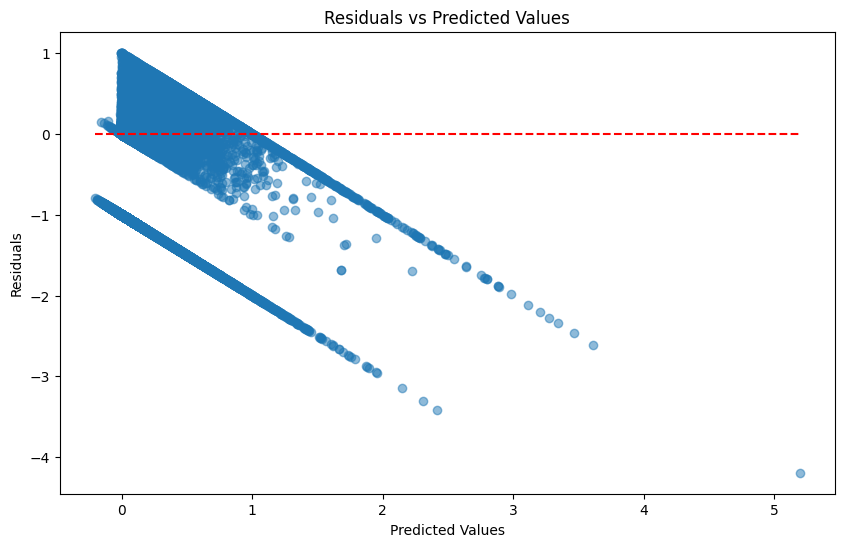

In [83]:
plot_residuals(y_true, y_pred)

In [ ]:
def calculate_correlation(y_true, y_pred):
    """
    Calculates the Pearson correlation coefficient between true and predicted values.

    Args:
        y_true: True intensities.
        y_pred: Predicted intensities.

    Returns:
        Pearson correlation coefficient.
    """
    y_true_flat = np.concatenate(y_true)
    y_pred_flat = np.concatenate(y_pred)
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]


In [88]:

# Example usage:
correlation = calculate_correlation(y_true, y_pred)
print(f'Pearson correlation coefficient: {correlation}')


Pearson correlation coefficient: 0.22620620302040179
